In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [2]:
df=pd.read_csv("equipment_anomaly_data_with_timestamp.csv")

In [3]:
df.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty,timestamp
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0,2024-01-01
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0,2024-01-02
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0,2024-01-03
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0,2024-01-04
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0,2024-01-05


In [4]:
df=df.drop(['equipment'],axis=1)

In [5]:
df=df.drop(['location'],axis=1)

In [6]:
df=df.drop(['timestamp'],axis=1)

In [7]:
df=df.drop(['faulty'],axis=1)  # As we do not require the fault status as of now we will remove and detect new anomalies using unsupervised methods

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
dtypes: float64(4)
memory usage: 239.9 KB


In [9]:
df.describe()

,temperature,pressure,vibration,humidity
count,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574
std,16.200059,10.381593,0.728560,11.841479
min,10.269385,3.620798,-0.428188,10.215077
25%,62.777057,29.485682,1.170906,42.612817
50%,70.156900,35.227544,1.533113,50.024744
75%,77.568387,41.159913,1.924700,57.340513
max,149.690420,79.887734,4.990537,89.984718


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
dtypes: float64(4)
memory usage: 239.9 KB


# Anomaly Detection using Isolationforest

In [11]:
from sklearn.ensemble import IsolationForest
X = df[['temperature', 'pressure', 'vibration', 'humidity']]

In [12]:
# Step 2: Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.2, random_state=42)
df['anomaly'] = iso_forest.fit_predict(X)

In [13]:
print(df[['temperature', 'pressure', 'vibration', 'humidity', 'anomaly']])
# -1 = anomaly, 1 = normal

      temperature   pressure  vibration   humidity  anomaly
0       58.180180  25.029278   0.606516  45.694907        1
1       75.740712  22.954018   2.338095  41.867407        1
2       71.358594  27.276830   1.389198  58.954409        1
3       71.616985  32.242921   1.770690  40.565138        1
4       66.506832  45.197471   0.345398  43.253795        1
...           ...        ...        ...        ...      ...
7667    65.711521  37.505934   2.030521  49.331471        1
7668    63.005855  45.164234   1.264585  61.905390        1
7669    72.029230  34.757896   1.709046  49.972917        1
7670   107.086485  23.754114   1.142522  23.967977       -1
7671    28.468054  66.588978   4.677368  79.670225       -1

[7672 rows x 5 columns]


In [14]:
df['anomaly'].value_counts()

anomaly
 1    6137
-1    1535
Name: count, dtype: int64

Confusion Matrix:
 [[1197   22]
 [  23  293]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.93      0.93       316
           1       0.98      0.98      0.98      1219

    accuracy                           0.97      1535
   macro avg       0.96      0.95      0.96      1535
weighted avg       0.97      0.97      0.97      1535



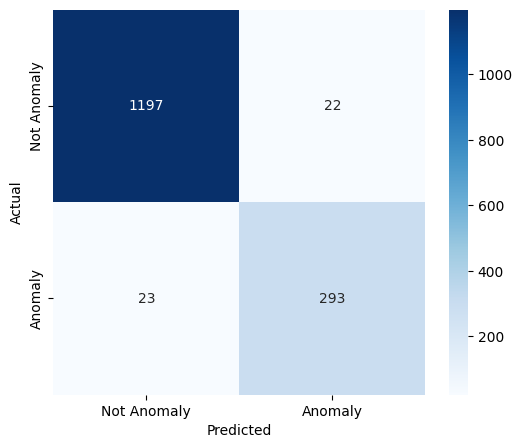

In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
X = df.drop('anomaly', axis=1)  # Features (drop the label column)
y = df['anomaly']     

# Split before SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 1: Train Isolation Forest (unsupervised)
iso = IsolationForest(random_state=42, contamination=0.2)  # tune contamination if needed
iso.fit(X_train)

# Step 2: Predict on the test set
# Isolation Forest returns -1 for anomaly and 1 for normal
y_pred_iso = iso.predict(X_test)

# Step 4: Confusion matrix
cm_iso = confusion_matrix(y_test, y_pred_iso,labels=[1, -1])
print("Confusion Matrix:\n", cm_iso)

# Optional: Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_iso))

plt.figure(figsize=(6, 5))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Anomaly', 'Anomaly'], yticklabels=['Not Anomaly', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

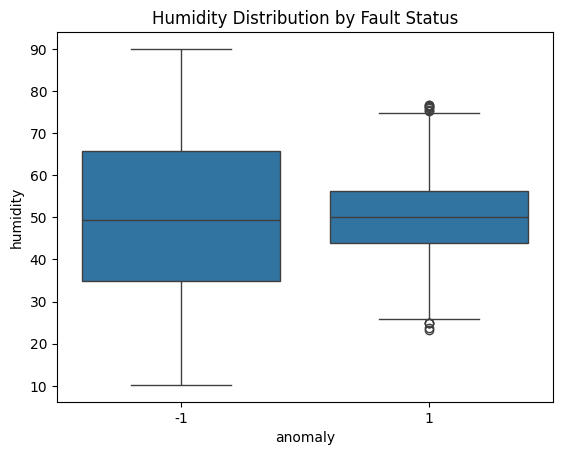

In [16]:
sns.boxplot(x='anomaly', y='humidity', data=df)
plt.title("Humidity Distribution by Fault Status")
plt.show()

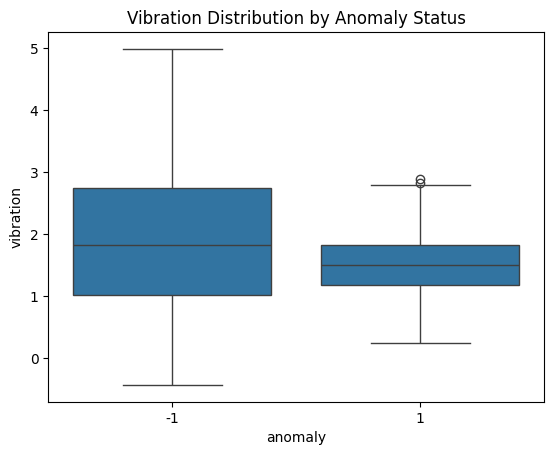

In [17]:
sns.boxplot(x='anomaly', y='vibration', data=df)
plt.title("Vibration Distribution by Anomaly Status")
plt.show()

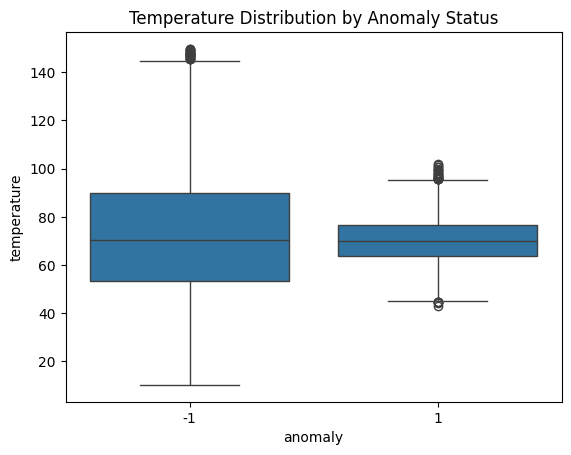

In [18]:
sns.boxplot(x='anomaly', y='temperature', data=df)
plt.title("Temperature Distribution by Anomaly Status")
plt.show()


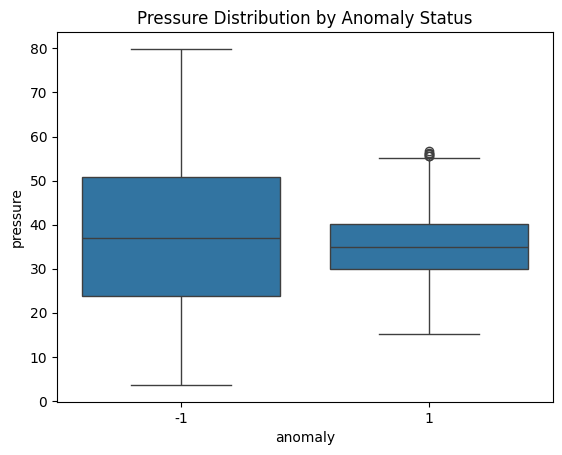

In [19]:
sns.boxplot(x='anomaly', y='pressure', data=df)
plt.title("Pressure Distribution by Anomaly Status")
plt.show()

   temperature   pressure  vibration   humidity  anomaly
0    58.180180  25.029278   0.606516  45.694907        1
1    75.740712  22.954018   2.338095  41.867407        1
2    71.358594  27.276830   1.389198  58.954409        1
3    71.616985  32.242921   1.770690  40.565138        1
4    66.506832  45.197471   0.345398  43.253795        1


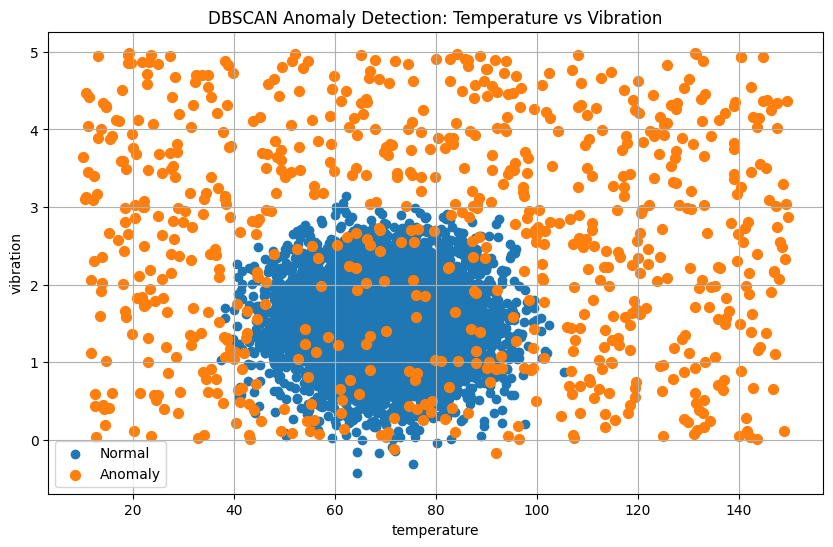

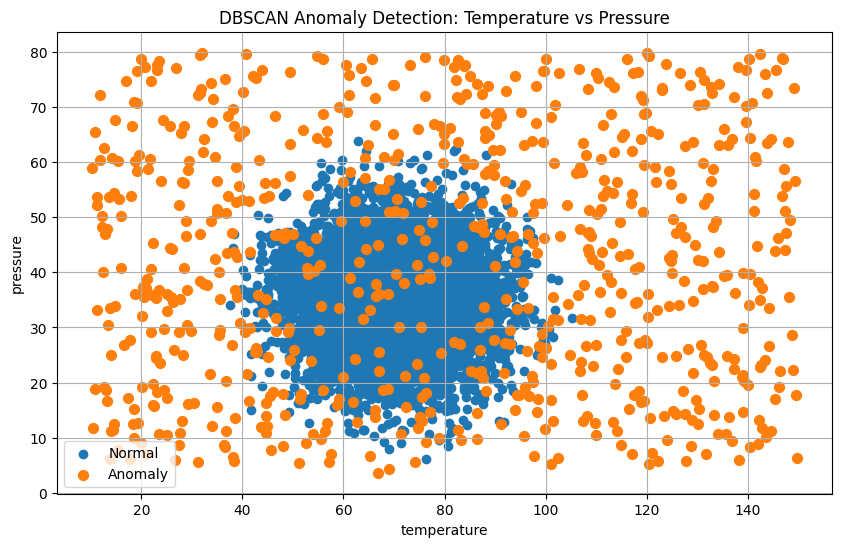

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


# Display first few rows (optional)
print(df.head())

# ----------------------------------------------
# 2. Select Features for Anomaly Detection
# ----------------------------------------------
features = ["temperature", "pressure", "humidity", "vibration"]
X = df[features]
# ----------------------------------------------
# 3. Preprocessing (Scaling)
# ----------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------------------------
# 4. Train DBSCAN Model
# ----------------------------------------------
dbscan = DBSCAN(eps=0.7, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Add labels to dataframe
df["Anomaly"] = labels   # -1 = anomaly

# Separate normal and anomaly points
normal = df[df["Anomaly"] != -1]
anomaly = df[df["Anomaly"] == -1]

# ----------------------------------------------
# 5. Plot 1: Temperature vs Vibration
# ----------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(normal["temperature"], normal["vibration"], label="Normal")
plt.scatter(anomaly["temperature"], anomaly["vibration"], s=50, label="Anomaly")

plt.xlabel("temperature")
plt.ylabel("vibration")
plt.title("DBSCAN Anomaly Detection: Temperature vs Vibration")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------
# 6. Plot 2: Temperature vs Pressure
# ----------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(normal["temperature"], normal["pressure"], label="Normal")
plt.scatter(anomaly["temperature"], anomaly["pressure"], s=50, label="Anomaly")

plt.xlabel("temperature")
plt.ylabel("pressure")
plt.title("DBSCAN Anomaly Detection: Temperature vs Pressure")
plt.legend()
plt.grid(True)
plt.show()


# Using SMOTE Technique to Handle Imblanaced Data

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
DF=pd.read_csv("updated_final_equipment_monitoring.csv")


In [22]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   faulty       7672 non-null   float64
 5   anomaly      7672 non-null   int64  
 6   status       7672 non-null   object 
 7   Year         7672 non-null   int64  
 8   Month        7672 non-null   int64  
 9   Date         7672 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 599.5+ KB


In [23]:
DF=DF.drop(['status'],axis=1)

In [24]:
print(DF['anomaly'].value_counts())
print(DF['anomaly'].value_counts(normalize=True))

anomaly
 1    6137
-1    1535
Name: count, dtype: int64
anomaly
 1    0.799922
-1    0.200078
Name: proportion, dtype: float64


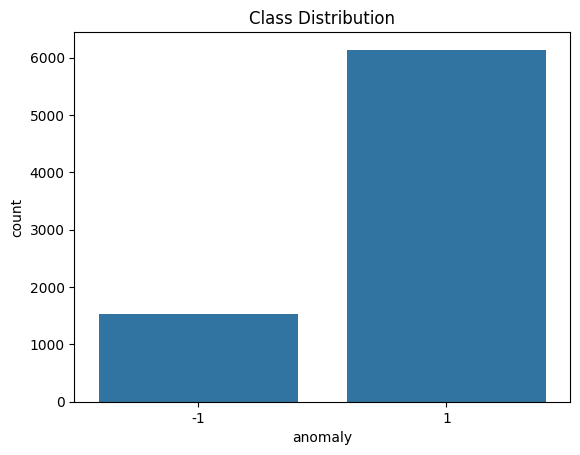

In [25]:
sns.countplot(x='anomaly', data=DF)
plt.title("Class Distribution")
plt.show()

In [26]:
from collections import Counter

counter = Counter(DF['anomaly'])
imbalance_ratio = max(counter.values()) / min(counter.values())
print("Imbalance Ratio:", imbalance_ratio)

Imbalance Ratio: 3.9980456026058633


# Random Forest (Supervised Learning)

In [28]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd

# Example: Separate features and labels
X = DF.drop('anomaly', axis=1)  # Features (drop the label column)
y = DF['anomaly']     

# Check original class distribution
print("Before SMOTE:", Counter(y))

# Split before SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("After SMOTE:", Counter(y_train_resampled))


Before SMOTE: Counter({1: 6137, -1: 1535})
After SMOTE: Counter({1: 4909, -1: 4909})


/Users/harshilpatel/.conda/envs/predictive_ML/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Step 4: Predict on test set
y_pred = rf.predict(X_test)

# Step 5: Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[ 280   27]
 [  45 1183]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.86      0.91      0.89       307
           1       0.98      0.96      0.97      1228

    accuracy                           0.95      1535
   macro avg       0.92      0.94      0.93      1535
weighted avg       0.95      0.95      0.95      1535

Accuracy: 0.9530944625407166


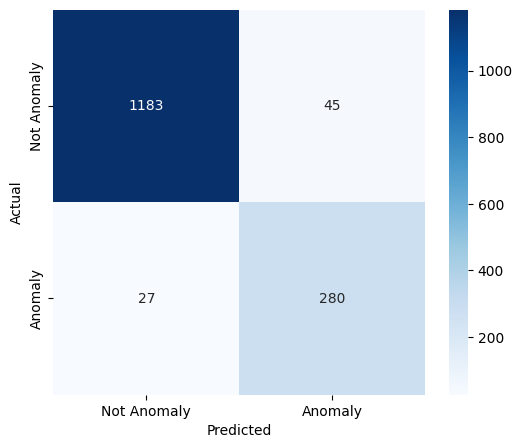

In [31]:
cm = confusion_matrix(y_test, y_pred,labels=[1, -1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Anomaly', 'Anomaly'], yticklabels=['Not Anomaly', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# K-Nearest Neighbor (Supervised Learning)

In [32]:
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import pandas as pd

# Step 1: Prepare data
X = DF.drop('anomaly', axis=1)
y = DF['anomaly']

# Step 2: Split data before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 3: Apply SMOTE on training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

# Step 4: Train KNN
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune k using GridSearchCV
knn.fit(X_train_resampled, y_train_resampled)

# Step 5: Predict on test set
y_pred_knn = knn.predict(X_test)

# Step 6: Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))


Before SMOTE: Counter({1: 4909, -1: 1228})
After SMOTE: Counter({1: 4909, -1: 4909})
Confusion Matrix:
 [[ 233   74]
 [ 137 1091]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.63      0.76      0.69       307
           1       0.94      0.89      0.91      1228

    accuracy                           0.86      1535
   macro avg       0.78      0.82      0.80      1535
weighted avg       0.88      0.86      0.87      1535

Accuracy: 0.8625407166123779


/Users/harshilpatel/.conda/envs/predictive_ML/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


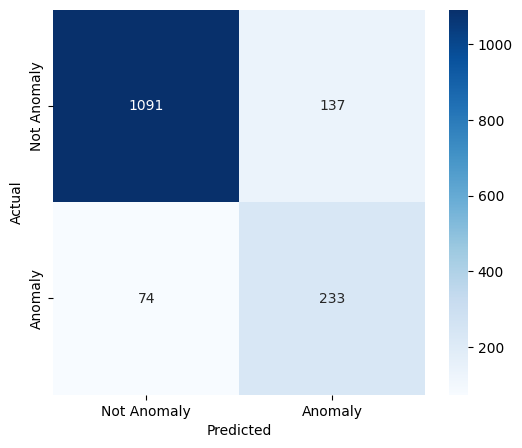

In [33]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn,labels=[1, -1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Anomaly', 'Anomaly'], yticklabels=['Not Anomaly', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Confusion Matrix:
 [[6137    0]
 [1188  347]]

Accuracy  : 0.8452
Precision : 1.0
Recall    : 0.2261
F1 Score  : 0.3688

Classification Report:
               precision    recall  f1-score   support

  Normal (1)       1.00      0.23      0.37      1535
Anomaly (-1)       0.84      1.00      0.91      6137

    accuracy                           0.85      7672
   macro avg       0.92      0.61      0.64      7672
weighted avg       0.87      0.85      0.80      7672



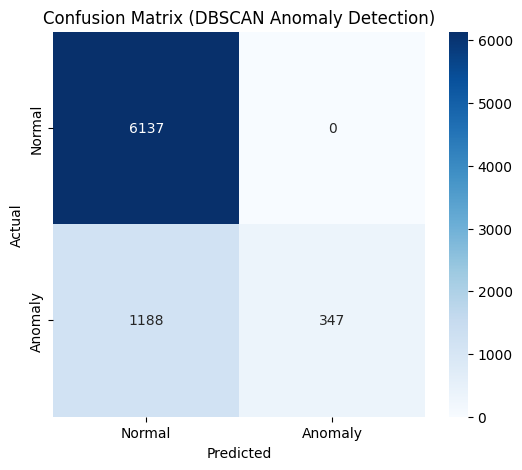

In [34]:
# ===============================
# DBSCAN Anomaly Detection Script
# ===============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)

# -------------------------------
# Load dataset
# -------------------------------
file_path = "updated_final_equipment_monitoring.csv"  # change path if needed
df = pd.read_csv(file_path)

# -------------------------------
# Keep only required parameters
# -------------------------------
params = ["temperature", "pressure", "humidity", "vibration"]
X = df[params]

# Ground truth labels from dataset
# anomaly column: -1 (Anomaly), 1 (Normal)
y_true = df["anomaly"]

# -------------------------------
# Standardize data
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# Apply DBSCAN
# -------------------------------
dbscan = DBSCAN(eps=1.0, min_samples=3)
labels = dbscan.fit_predict(X_scaled)

# Map DBSCAN output: -1 = anomaly, 1 = normal
y_pred = pd.Series(labels).apply(lambda x: -1 if x == -1 else 1)

# -------------------------------
# Performance Metrics
# -------------------------------
cm = confusion_matrix(y_true, y_pred, labels=[1, -1])
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label=-1)
recall = recall_score(y_true, y_pred, pos_label=-1)
f1 = f1_score(y_true, y_pred, pos_label=-1)
report = classification_report(y_true, y_pred,target_names=["Normal (1)", "Anomaly (-1)"])

# Print results
print("Confusion Matrix:\n", cm)
print("\nAccuracy  :", round(accuracy, 4))
print("Precision :", round(precision, 4))
print("Recall    :", round(recall, 4))
print("F1 Score  :", round(f1, 4))
print("\nClassification Report:\n", report)

# -------------------------------
# Confusion Matrix Visualization
# -------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (DBSCAN Anomaly Detection)")
plt.show()
